# 1. Gerekli Kütüphanelerin İçe Aktarılması:

Bu bölümde, metin işleme, model oluşturma ve eğitim için gerekli kütüphaneler içe aktarılır

In [1]:
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


# 2. Veri Setinin Yüklenmesi ve Temizlenmesİ:

file_path: Veri setinin dosya yolunu belirtir.

Veri yükleme ve temizleme: Veriyi dosyadan okur, küçük harfe çevirir ve noktalama işaretlerini temizler

In [2]:
file_path = '/content/trveriset.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()

data = data.lower()
data = re.sub(r'[^\w\s]', '', data)


# 3. Tokenizer Oluşturma ve Veri Setine Fit Etme

data.split('\n'): Veriyi satırlara böler.

Tokenizer: Kelimeleri sayısal değerlere dönüştürmek için kullanılır.

In [3]:
data = data.split('\n')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)


# 4. Dizilere Çevirme ve Padding

Kelime dizileri oluşturma: Her cümleyi sayısal değerlere dönüştürür.

Padding: Tüm dizileri aynı uzunlukta yapar.

In [4]:
sequences = []
for line in data:
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')


# 5. Giriş (X) ve Çıkış (y) Değerlerini Ayırma

X, y ayırma: Giriş ve çıkış verilerini ayırır.

Kategorik dönüşüm: Çıkış verilerini kategorik formata çevirir.

In [5]:
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

vocab_size = len(tokenizer.word_index) + 1
y = to_categorical(y, num_classes=vocab_size)


# 6. Modeli Oluşturma ve Derleme

Model katmanları: Embedding, LSTM ve Dropout katmanları eklenir.

Model derleme: Model, categorical_crossentropy kaybı ve adam optimizer ile derlenir.

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length-1))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           562900    
                                                                 
 lstm (LSTM)                 (None, 17, 150)           150600    
                                                                 
 dropout (Dropout)           (None, 17, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 5629)              849979    
                                                                 
Total params: 1744079 (6.65 MB)
Trainable params: 174407

# 7. Callbacks Tanımlama

ModelCheckpoint: En iyi modeli kaydeder.

EarlyStopping: Eğitim sırasında kaybın iyileşmediği durumlarda erken durdurma sağlar.

In [7]:
checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=10)
callbacks_list = [checkpoint, early_stopping]


# 8. Modeli Eğitme ve Eğitim Geçmişini Kaydetme

Model eğitimi: Modeli eğitim verileri üzerinde eğitir ve eğitim geçmişini history nesnesine kaydeder.


In [8]:
history = model.fit(X, y, epochs=250, batch_size=128, callbacks=callbacks_list)


Epoch 1/250
254/254 [==============================] - ETA: 0s - loss: 7.4171 - accuracy: 0.0247
Epoch 1: loss improved from inf to 7.41714, saving model to model.h5
254/254 [==============================] - 19s 55ms/step - loss: 7.4171 - accuracy: 0.0247
Epoch 2/250
 15/254 [>.............................] - ETA: 1s - loss: 6.9005 - accuracy: 0.0250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - ETA: 0s - loss: 6.8633 - accuracy: 0.0273
Epoch 2: loss improved from 7.41714 to 6.86327, saving model to model.h5
254/254 [==============================] - 4s 16ms/step - loss: 6.8633 - accuracy: 0.0273
Epoch 3/250
254/254 [==============================] - ETA: 0s - loss: 6.4127 - accuracy: 0.0410
Epoch 3: loss improved from 6.86327 to 6.41266, saving model to model.h5
254/254 [==============================] - 4s 15ms/step - loss: 6.4127 - accuracy: 0.0410
Epoch 4/250
254/254 [==============================] - ETA: 0s - loss: 5.9636 - accuracy: 0.0595
Epoch 4: loss improved from 6.41266 to 5.96363, saving model to model.h5
254/254 [==============================] - 3s 11ms/step - loss: 5.9636 - accuracy: 0.0595
Epoch 5/250
254/254 [==============================] - ETA: 0s - loss: 5.5958 - accuracy: 0.0935
Epoch 5: loss improved from 5.96363 to 5.59581, saving model to model.h5
254/254 [==============================] - 3s 12ms/step - loss

# 9. Eğitim Sonuçlarını Görselleştirme

Grafikler: Eğitim sürecindeki kayıp ve doğruluk değerlerini grafik olarak çizer.

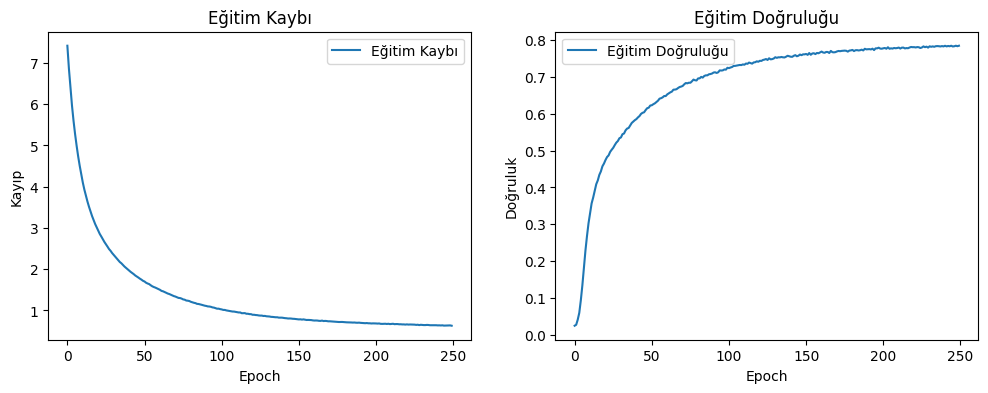

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.title('Eğitim Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.title('Eğitim Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


# 10. Tahmin Fonksiyonu

generate_text: Girilen metni tamamlamak için modelin tahmin ettiği kelimeleri ekler.

In [10]:
def generate_text(model, tokenizer, text, num_words_to_predict=1):
    for _ in range(num_words_to_predict):
        encoded = tokenizer.texts_to_sequences([text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length-1, padding='pre')

        y_pred = model.predict(encoded, verbose=0)
        predicted_word = tokenizer.index_word[np.argmax(y_pred)]

        text += ' ' + predicted_word

        if predicted_word == 'end':
            break

    return text


# 11. Arayüz Bileşenleri

Arayüz bileşenleri: Kullanıcı girişi ve modelin tahminlerini göstermek için arayüz bileşenleri oluşturulur.


In [11]:
text_box = widgets.Text(
    value='',
    placeholder='Eksik cümlenizi buraya yazın',
    description='Cümle:',
    disabled=False
)

output_label = widgets.Label(value='Tamamlanmış cümle burada görünecek')

word_count_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Kelime Sayısı:',
    continuous_update=False
)

button = widgets.Button(
    description='Tahmin Et',
    disabled=False,
    button_style='',
    tooltip='Tahmin Et',
    icon='check'
)


# 12. Buton Tıklama Olayı Ve Arayüzü Görüntüleme

Buton olayı: Butona tıklandığında tahmin fonksiyonu çalıştırılır ve sonuç gösterilir

Arayüzü göster: Arayüz bileşenlerini ekranda gösterir.


In [12]:
def on_button_click(b):
    input_text = text_box.value
    num_words_to_predict = word_count_slider.value
    if input_text.strip():
        completed_text = generate_text(model, tokenizer, input_text, num_words_to_predict)
        output_label.value = f"Tahmin Edilen Cümle: {completed_text}"
        text_box.value = completed_text

button.on_click(on_button_click)

# Arayüzü görüntüle
display(text_box, word_count_slider, button, output_label)


Text(value='', description='Cümle:', placeholder='Eksik cümlenizi buraya yazın')

IntSlider(value=1, continuous_update=False, description='Kelime Sayısı:', max=10, min=1)

Button(description='Tahmin Et', icon='check', style=ButtonStyle(), tooltip='Tahmin Et')

Label(value='Tamamlanmış cümle burada görünecek')